In [1]:
# Load data from csv file

import csv
import numpy as np
dates = []
times = []
loads = []
with open('data.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        dates.append(row['Date'])
        times.append(row['Time'])
        loads.append(float(row['Load']))

dates = np.array(dates)
times = np.array(times)
loads = np.array(loads)

print("Date:", dates[0])
print("Time:", times[0])
print("Load:", loads[0])

n = dates.size


Date: 01-10-2007
Time: 00;00:00
Load: 1.324


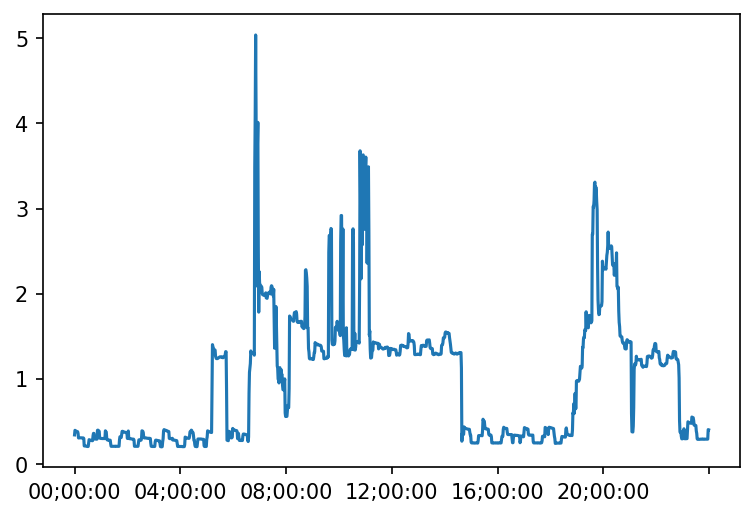

In [3]:
# Visualization data within one day
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100


target_date = '05-10-2007'

x_major_locator=MultipleLocator(240)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.plot([times[i] for i in range(n) if dates[i]==target_date],
         [loads[i] for i in range(n) if dates[i]==target_date])

plt.show()